In [30]:
import os
import sys
working_dir = os.path.join(os.getcwd().split("Text2BGAudio")[0],'Text2BGAudio')
sys.path.append(working_dir)
os.chdir(working_dir)
from datasets import load_dataset
from transformers import ClapModel, ClapProcessor
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter,defaultdict
from tqdm import tqdm
from Dataset_Creation import audio_dataset
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")

CLAP_ARCH = "laion/larger_clap_music"


Device Name: NVIDIA GeForce RTX 4080 SUPER


In [40]:
data_path = r"_Data\Music\Music Data New\music_dataset_fixed_Music Data New_tr3141_val390_te398.pt"
clap_model_path = r"CLAP\models\new_fixed\clap_fine_tunned_Fixeed_BatchSize_32_LR_1e-05_Epochs_400_VAL_LOSS_26.47.pt"

In [31]:
class EmbeddedDataset(Dataset):
    def __init__(self, embedded_data):
        self.embedded_data = embedded_data
    def __len__(self):
        return len(self.embedded_data)
    def __getitem__(self, idx):
        x,y= self.embedded_data[idx]
        return x,y

criterion = torch.nn.CrossEntropyLoss()
class MLPHead(torch.nn.Module):
    def __init__(self, input_dim=512, output_dim=6, hidden_dim=256):
        super(MLPHead, self).__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim),
            torch.nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.mlp(x)
    
label_to_index  = {'anger' : 0, 'joy' : 1, 'love' : 2, 'sadness' : 3, 'fear' : 4, 'surprise' : 5}
index_to_label = {v: k for k, v in label_to_index.items()}

In [32]:
def create_embedded_ds_v2(dataset,clap_model,processor):
    embedded_data = list()
    with torch.no_grad():
        data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
        for batch in tqdm(data_loader,desc="Batches"):
            audio = batch[0]
            labels = list(batch[1])
            unique_labels = list(set(labels))
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            embedded_data.extend([(audio_embed.cpu().detach(), label_to_index[label]) for audio_embed, label in zip(audio_embeds, labels)])
    return EmbeddedDataset(embedded_data)

## Load Data

In [ ]:
train_data, val_data, test_data = list(torch.load(data_path, weights_only=False).values())
train_dataset = audio_dataset.AudioDataset(train_data)
val_dataset = audio_dataset.AudioDataset(val_data)
test_dataset = audio_dataset.AudioDataset(test_data)

## Train MLP Head on CLAP

### Create embedded DS

In [ ]:
clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
processor = ClapProcessor.from_pretrained(CLAP_ARCH)
if clap_model_path is not None:
    clap_model.load_state_dict(torch.load(clap_model_path,weights_only=False)['model_state_dict'])

In [ ]:
train_dataset_embedded = create_embedded_ds_v2(train_dataset,clap_model,processor)
val_dataset_embedded = create_embedded_ds_v2(val_dataset,clap_model,processor)
test_dataset_embedded = create_embedded_ds_v2(test_dataset,clap_model,processor)



Batches:  18%|█▊        | 18/99 [00:10<00:44,  1.83it/s]

### Train HEAD

Epoch 1/1000, Loss: 1.4205330610275269, Train Acc : 0.9134033747214263 , Val Acc : 0.7282051282051282
Epoch 2/1000, Loss: 1.1087255477905273, Train Acc : 0.9821712830308819 , Val Acc : 0.7333333333333333
Epoch 3/1000, Loss: 1.0833653211593628, Train Acc : 0.9831263928685132 , Val Acc : 0.7333333333333333
Epoch 4/1000, Loss: 1.054121971130371, Train Acc : 0.9847182425978988 , Val Acc : 0.7256410256410256
Epoch 5/1000, Loss: 1.0475623607635498, Train Acc : 0.9837631327602674 , Val Acc : 0.7256410256410256
Epoch 6/1000, Loss: 1.0504374504089355, Train Acc : 0.9850366125437758 , Val Acc : 0.7307692307692307
Epoch 7/1000, Loss: 1.0733047723770142, Train Acc : 0.9850366125437758 , Val Acc : 0.7307692307692307
Epoch 8/1000, Loss: 1.0749655961990356, Train Acc : 0.9850366125437758 , Val Acc : 0.7307692307692307
Epoch 9/1000, Loss: 1.0470795631408691, Train Acc : 0.9850366125437758 , Val Acc : 0.7307692307692307
Epoch 10/1000, Loss: 1.0476512908935547, Train Acc : 0.985354982489653 , Val Acc : 

Text(0, 0.5, 'Accuracy')

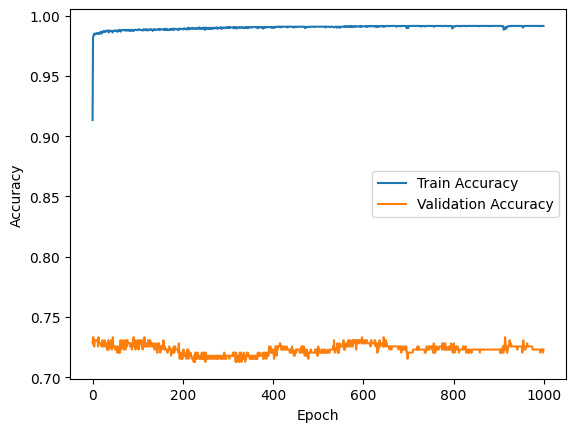

In [ ]:
batch_size = 128
epochs = 1000
train_data_loader = DataLoader(train_dataset_embedded, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset_embedded, batch_size=batch_size, shuffle=True)

classification_head = MLPHead().to(DEVICE)
optimizer = torch.optim.Adam(classification_head.parameters(), lr=1e-3)

train_acc = list()
val_acc = list()
for e in range(epochs):
    train_correct = 0
    for batch in train_data_loader:
        audio_embeds, labels = batch
        audio_embeds = audio_embeds.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == labels).item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_acc.append(train_correct/len(train_dataset))
    with torch.no_grad():
        val_correct = 0
        for batch in val_data_loader:
            audio_embeds, labels = batch
            audio_embeds = audio_embeds.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = classification_head(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == labels).item()
        val_acc.append(val_correct/len(val_dataset))
    print(f"Epoch {e+1}/{epochs}, Loss: {loss.item()}, Train Acc : {train_acc[-1]} , Val Acc : {val_acc[-1]}")


plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


In [ ]:
test_data_loader = DataLoader(test_dataset_embedded, batch_size=batch_size, shuffle=True)

with torch.no_grad():
    test_correct = 0
    for batch in test_data_loader:
        audio_embeds, labels = batch
        audio_embeds = audio_embeds.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = classification_head(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        test_correct += torch.sum(est_classification == labels).item()
    test_acc = val_correct/len(test_dataset)
print(f"Test Acc : {test_acc}")

NameError: name 'test_dataset_embedded' is not defined

### Train CLAP and MLP together

In [ ]:
# Load the model and processor
processor = ClapProcessor.from_pretrained(CLAP_ARCH)
clap_model = ClapModel.from_pretrained(CLAP_ARCH).to(DEVICE)
clap_model.load_state_dict(torch.load(clap_model_path, weights_only=False)['model_state_dict'])

# Initialize the MLP head
MLP_HEAD = MLPHead().to(DEVICE)
for param in clap_model.parameters():
    param.requires_grad = False
# Unfreeze audio projection heads
# for param in clap_model.audio_projection.parameters():
#     param.requires_grad = True

# Hyperparameters
epochs = 50
batch_size = 128

# Data loaders
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Optimizer
optimizer = torch.optim.AdamW(
    [
        # {'params': clap_model.parameters(), 'lr': 1e-5},
        {'params': MLP_HEAD.parameters(), 'lr': 1e-3}
    ]
)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Accuracy lists
acc_list = {"train": [], "val": []}

# Training loop
for e in range(epochs):
    clap_model.train()
    MLP_HEAD.train()
    train_correct = 0
    total_loss = 0
    for batch in tqdm(train_data_loader, desc="Train Batches"):
        audio = batch[0]
        train_labels = list(batch[1])
        unique_labels = train_labels[:1]  # Not needed for inference
        inputs = processor(
            text=unique_labels,
            audios=audio.numpy(),
            return_tensors="pt",
            sampling_rate=48000,
            padding=True,
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = clap_model(**inputs)
        audio_embeds = outputs.audio_embeds
        outputs = MLP_HEAD(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        train_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in train_labels]).to(DEVICE)).item()
        loss = criterion(outputs, torch.tensor([label_to_index[label] for label in train_labels]).to(DEVICE))
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_acc = train_correct / len(train_dataset)
    acc_list['train'].append(train_acc)
    
    clap_model.eval()
    MLP_HEAD.eval()
    val_correct = 0
    with torch.no_grad():
        for batch in tqdm(val_data_loader,desc="Val Batches"):
            audio = batch[0]
            val_labels = list(batch[1])
            unique_labels = val_labels[:1]
            inputs = processor(
                text=unique_labels,
                audios=audio.numpy(),
                return_tensors="pt",
                sampling_rate=48000,
                padding=True,
            )
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = clap_model(**inputs)
            audio_embeds = outputs.audio_embeds
            outputs = MLP_HEAD(audio_embeds)
            est_classification = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in val_labels]).to(DEVICE)).item()
    val_acc = val_correct / len(val_dataset)
    acc_list['val'].append(val_acc)
    
    print(f"Epoch {e+1}/{epochs}, Loss: {total_loss / len(train_data_loader)}, Train Acc: {train_acc}, Val Acc: {val_acc}\n")

# Print final accuracies
print("Final Training Accuracy:", acc_list['train'][-1])
print("Final Validation Accuracy:", acc_list['val'][-1])

Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 1/50, Loss: 1.665837721824646, Train Acc: 0.9210442534224769, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 2/50, Loss: 1.22249680519104, Train Acc: 0.9789875835721108, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 3/50, Loss: 1.078452982902527, Train Acc: 0.9805794333014963, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 4/50, Loss: 1.0682252025604249, Train Acc: 0.9812161731932506, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch 5/50, Loss: 1.0674840688705445, Train Acc: 0.9805794333014963, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 6/50, Loss: 1.064373617172241, Train Acc: 0.9821712830308819, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 7/50, Loss: 1.0636892747879028, Train Acc: 0.9815345431391277, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 8/50, Loss: 1.0638294315338135, Train Acc: 0.9818529130850048, Val Acc: 0.7230769230769231



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 9/50, Loss: 1.0652803182601929, Train Acc: 0.9815345431391277, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 10/50, Loss: 1.06309796333313, Train Acc: 0.9824896529767589, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 11/50, Loss: 1.0639658212661742, Train Acc: 0.9815345431391277, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 12/50, Loss: 1.0617134523391725, Train Acc: 0.9837631327602674, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.99s/it]


Epoch 13/50, Loss: 1.0614735460281373, Train Acc: 0.9831263928685132, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 14/50, Loss: 1.0628968858718872, Train Acc: 0.9802610633556192, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]


Epoch 15/50, Loss: 1.062548975944519, Train Acc: 0.9815345431391277, Val Acc: 0.7256410256410256



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Epoch 16/50, Loss: 1.0596415901184082, Train Acc: 0.9856733524355301, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


Epoch 17/50, Loss: 1.062864580154419, Train Acc: 0.9821712830308819, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 18/50, Loss: 1.0616270685195923, Train Acc: 0.9834447628143903, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]


Epoch 19/50, Loss: 1.0613030624389648, Train Acc: 0.9824896529767589, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch 20/50, Loss: 1.063984694480896, Train Acc: 0.9793059535179879, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch 21/50, Loss: 1.0628832149505616, Train Acc: 0.9818529130850048, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch 22/50, Loss: 1.0613979291915894, Train Acc: 0.9812161731932506, Val Acc: 0.7384615384615385



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 23/50, Loss: 1.0592125606536866, Train Acc: 0.9847182425978988, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Epoch 24/50, Loss: 1.0628024673461913, Train Acc: 0.9824896529767589, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


Epoch 25/50, Loss: 1.0593740463256835, Train Acc: 0.9847182425978988, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 26/50, Loss: 1.0621318674087525, Train Acc: 0.9808978032473734, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 27/50, Loss: 1.061797547340393, Train Acc: 0.9821712830308819, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 28/50, Loss: 1.0616459798812867, Train Acc: 0.9818529130850048, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 29/50, Loss: 1.060444574356079, Train Acc: 0.9834447628143903, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 30/50, Loss: 1.062983193397522, Train Acc: 0.9824896529767589, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 31/50, Loss: 1.0602288389205932, Train Acc: 0.9837631327602674, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 32/50, Loss: 1.0591100835800171, Train Acc: 0.9859917223814072, Val Acc: 0.7256410256410256



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 33/50, Loss: 1.062156548500061, Train Acc: 0.9805794333014963, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 34/50, Loss: 1.0604002666473389, Train Acc: 0.9831263928685132, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 35/50, Loss: 1.0620458984375, Train Acc: 0.9808978032473734, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 36/50, Loss: 1.0608152627944947, Train Acc: 0.9831263928685132, Val Acc: 0.7282051282051282



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 37/50, Loss: 1.0630603551864624, Train Acc: 0.9831263928685132, Val Acc: 0.7256410256410256



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.95s/it]


Epoch 38/50, Loss: 1.0617217254638671, Train Acc: 0.9821712830308819, Val Acc: 0.7333333333333333



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch 39/50, Loss: 1.0608261013031006, Train Acc: 0.9828080229226361, Val Acc: 0.7384615384615385



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


Epoch 40/50, Loss: 1.0610030174255372, Train Acc: 0.9821712830308819, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 41/50, Loss: 1.0598915815353394, Train Acc: 0.9847182425978988, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


Epoch 42/50, Loss: 1.0605062675476074, Train Acc: 0.9831263928685132, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 43/50, Loss: 1.0628055095672608, Train Acc: 0.9815345431391277, Val Acc: 0.7410256410256411



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch 44/50, Loss: 1.0631033658981324, Train Acc: 0.9812161731932506, Val Acc: 0.735897435897436



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


Epoch 45/50, Loss: 1.0621561336517333, Train Acc: 0.9808978032473734, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


Epoch 46/50, Loss: 1.0614662456512451, Train Acc: 0.9821712830308819, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Epoch 47/50, Loss: 1.0599238443374634, Train Acc: 0.9837631327602674, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Epoch 48/50, Loss: 1.0632758951187133, Train Acc: 0.9799426934097422, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch 49/50, Loss: 1.0602104234695435, Train Acc: 0.9828080229226361, Val Acc: 0.7307692307692307



Val Batches: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

Epoch 50/50, Loss: 1.0609272289276124, Train Acc: 0.9828080229226361, Val Acc: 0.7282051282051282

Final Training Accuracy: 0.9828080229226361
Final Validation Accuracy: 0.7282051282051282


In [44]:
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_correct = 0
with torch.no_grad():
    for batch in tqdm(test_data_loader,desc="Test Batches"):
        audio = batch[0]
        val_labels = list(batch[1])
        unique_labels = val_labels[:1]
        inputs = processor(
            text=unique_labels,
            audios=audio.numpy(),
            return_tensors="pt",
            sampling_rate=48000,
            padding=True,
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = clap_model(**inputs)
        audio_embeds = outputs.audio_embeds
        outputs = MLP_HEAD(audio_embeds)
        est_classification = torch.argmax(outputs, dim=1)
        test_correct += torch.sum(est_classification == torch.tensor([label_to_index[label] for label in val_labels]).to(DEVICE)).item()
    test_acc = val_correct / len(val_dataset)
    print(f"Test Acc: {test_acc}\n")

Test Batches: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it]

Test Acc: 0.7282051282051282

